In [1]:
import torch # pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, os, shutil, glob, json
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from utils.Files import *
pd.set_option('display.max_columns', None)

In [2]:
MULTICLASS = True  # cada landmark ou apenas binário  
TILE_SIZE     = 0   # se for 0 não há implementaçaõ
AUG_PER_IMAGE = 0   # se for 0 não há implementação

In [3]:
images = [loadFile(img) for img in getFiles('database/target/images')]
masks  = [loadFile(img) for img in getFiles('database/target/masks')]

IMG_SIZE = images[0].shape[0]
print(IMG_SIZE)
images[:5]

128


[array([[[0.5026313 , 0.5026313 , 0.5026313 , ..., 0.4836204 ,
          0.4791169 , 0.47258404],
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.47092772,
          0.46766356, 0.4645351 ],
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.46536985,
          0.4653134 , 0.4623227 ],
         ...,
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.44442868,
          0.45259112, 0.46502268],
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.5265674 ,
          0.53611207, 0.55246   ],
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.59355617,
          0.604294  , 0.62242967]],
 
        [[0.5026313 , 0.5026313 , 0.5026313 , ..., 0.4860953 ,
          0.48056698, 0.4722805 ],
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.47457474,
          0.47272897, 0.46647102],
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.46748713,
          0.4678237 , 0.46523014],
         ...,
         [0.5026313 , 0.5026313 , 0.5026313 , ..., 0.44440904,
          0.45514682, 0.

# VERIFICAÇÃO DE INTEGRIDADE

In [4]:
len(images) == len(masks)

True

In [5]:
np.unique(images[:30])

array([0.0000000e+00, 3.8623662e-06, 5.6179874e-06, ..., 9.9999458e-01,
       9.9999875e-01, 1.0000000e+00], shape=(8234563,), dtype=float32)

In [6]:
np.unique(masks[:30])

array([0., 1., 2., 3., 4.], dtype=float32)

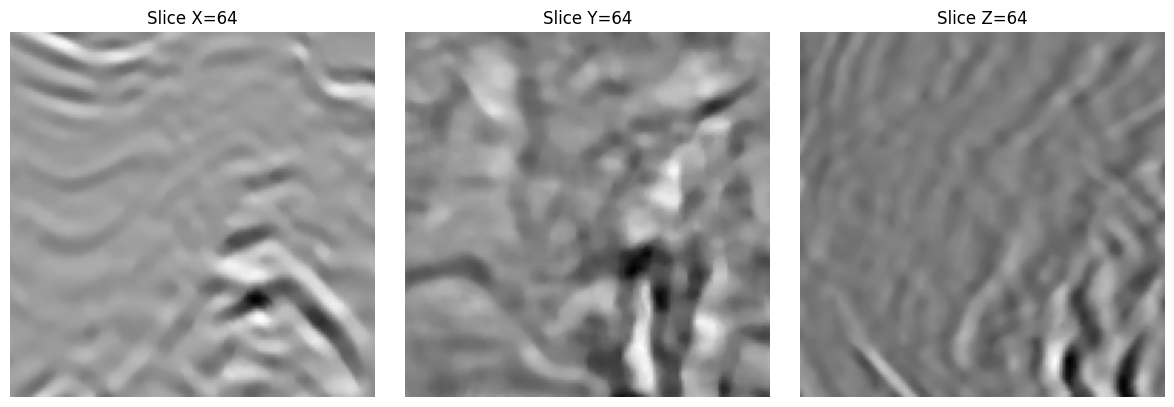

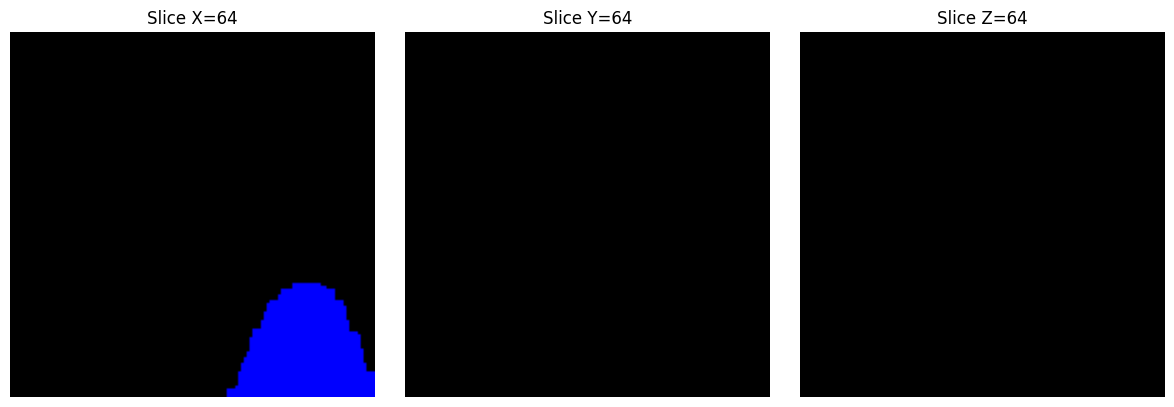

In [7]:
showTile(images[30])
showTile(masks[30], mask=True)

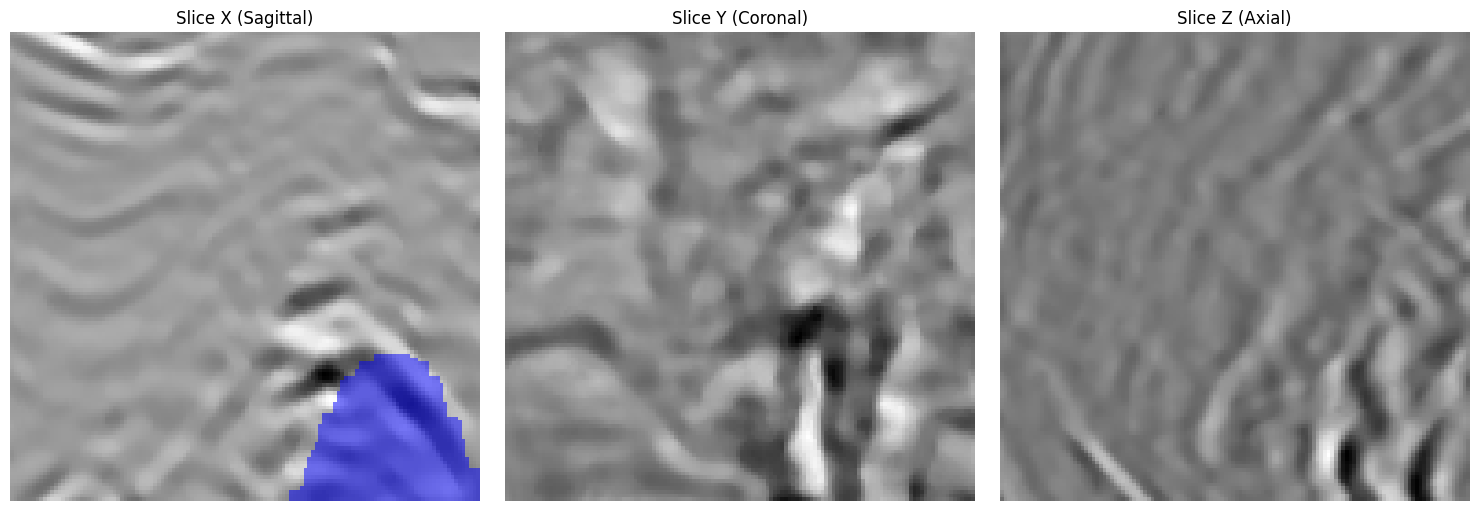

In [26]:
pasteMask(images[30], masks[30])

In [27]:
len(images) == len(masks)

True

# SPLITS DOS DADOS

In [28]:
VAL_SIZE  = 0.10
TEST_SIZE = 0.10
VAL_SIZE  = VAL_SIZE / (1 - TEST_SIZE)

In [29]:
xTemp, xTest, yTemp, yTest = train_test_split(images, masks, test_size=TEST_SIZE, random_state=42)
del images, masks
xTrain, xVal, yTrain, yVal = train_test_split(xTemp, yTemp, test_size=VAL_SIZE, random_state=42)
del xTemp, yTemp

print(f'train: {len(yTrain)} files')
print(f'val:   {len(yVal)} files')
print(f'test:  {len(yTest)} files')

train: 475 files
val:   60 files
test:  60 files


# SALVANDO DADOS

In [30]:
class Saver:
    def __init__(self, target='processed'):
        self.DIR   = os.path.join(f'database', target)
        self.index = 0
        
        for split in ['train', 'val', 'test']:
            setFolder(f'{self.DIR}/{split}/images')
            setFolder(f'{self.DIR}/{split}/masks')

    def to(self, split, img, mask):
        path = os.path.join(self.DIR, split)
        self.index = (self.index + 1)
        
        if TILE_SIZE == 0:
            np.save(f'{path}/images/img_{self.index}.npy', img)
            np.save(f'{path}/masks/img_{self.index}.npy', mask)
            return
        
        imgs, masks = tiles.get(img, mask)
        for t, (img, mask) in enumerate(zip(imgs, masks)):
            np.save(f'{path}/images/img_{self.index:04d}.npy', img)
            np.save(f'{path}/masks/img_{self.index:04d}.npy', mask)

    def dataset(self, split, images, masks):
        for img, mask in zip(images, masks):
            self.to(split, img, mask)

            if AUG_PER_IMAGE > 0 and split == 'train':
                xData, yData = aug.compute(img, mask, AUG_PER_IMAGE)
                
                for img, mask in zip(xData, yData):
                    self.to(split, img, mask)

        total = os.listdir(f"{self.DIR}/{split}/images").__len__()
        print(f'{split}: {total} images')


saver = Saver('processed')
saver.dataset('train', xTrain, yTrain)
saver.dataset('val',   xVal,   yVal)
saver.dataset('test',  xTest,  yTest)
del xTrain, yTrain, xVal, yVal, xTest, yTest

train: 475 images
val: 60 images
test: 60 images


In [31]:
data = {
   'dataset': 'dataset1',
   'tile_size': TILE_SIZE, 
   'img_size': IMG_SIZE,
   'n_aug': AUG_PER_IMAGE, 
   'n_images': len(getAllFiles('database/target/images')),
   'multiclass': MULTICLASS
}

with open(f'database/info.json', 'w', encoding='utf-8') as file:
   json.dump(data, file, ensure_ascii=False, indent=4)

# VISUALIZAÇÃO

showing img 0


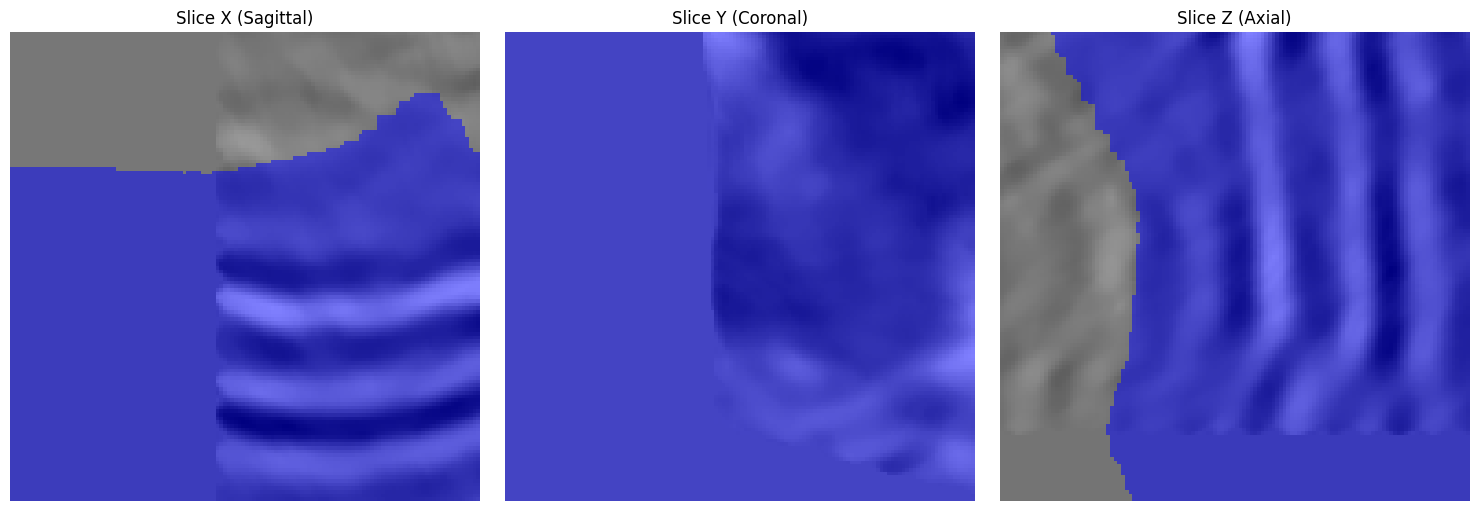

showing img 1


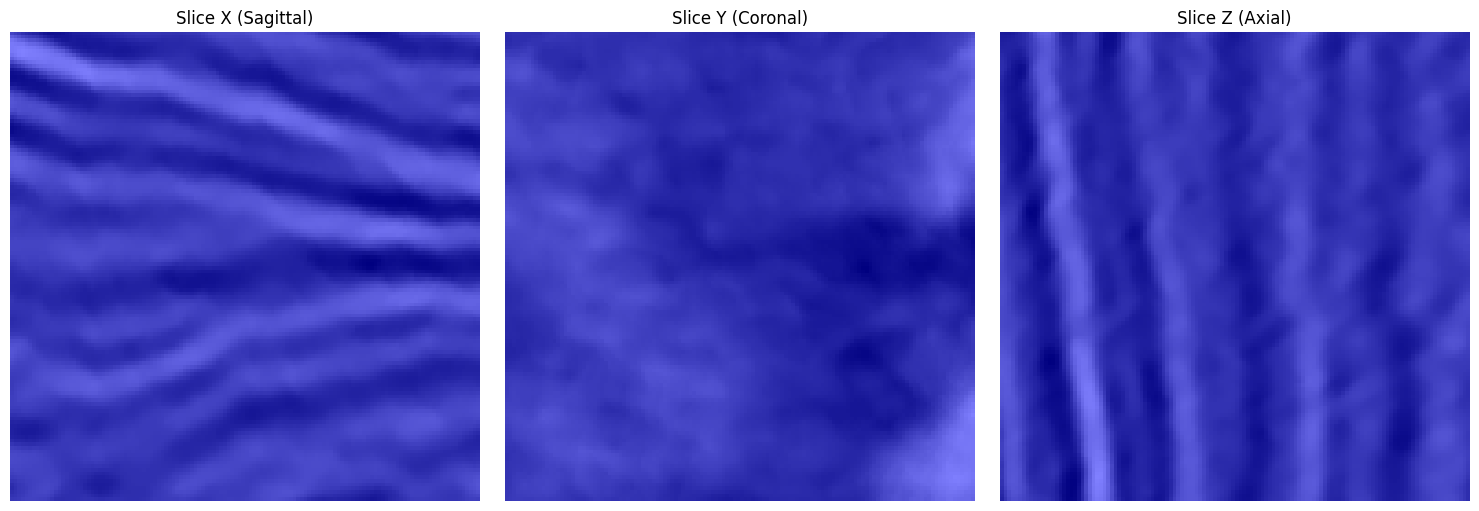

showing img 2


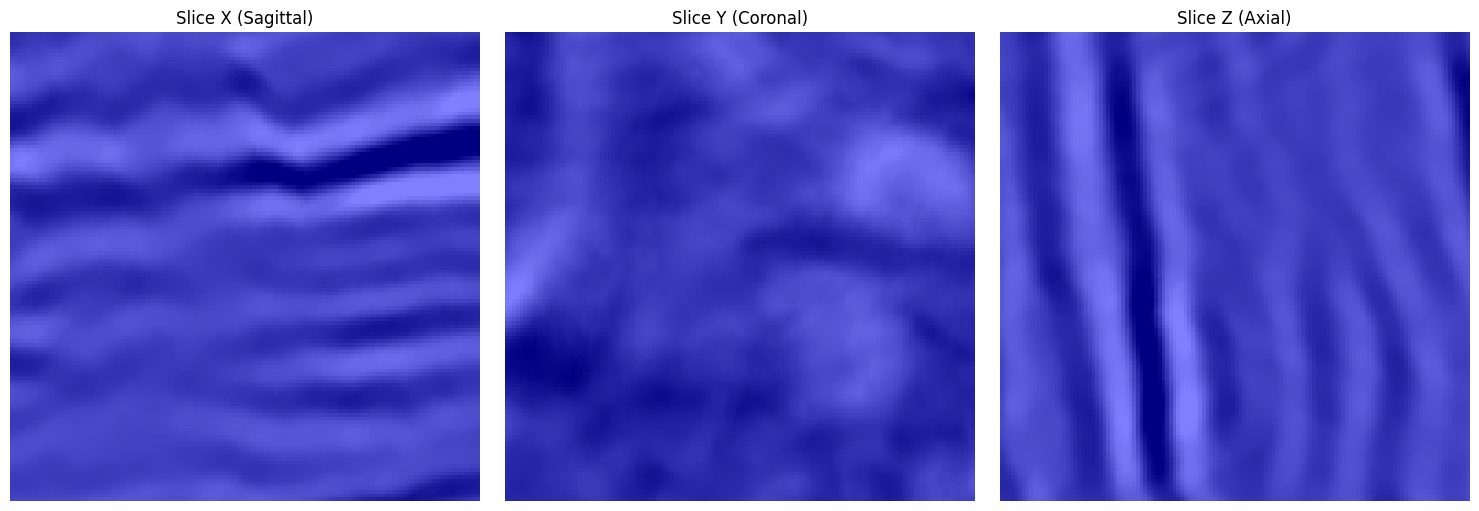

showing img 3


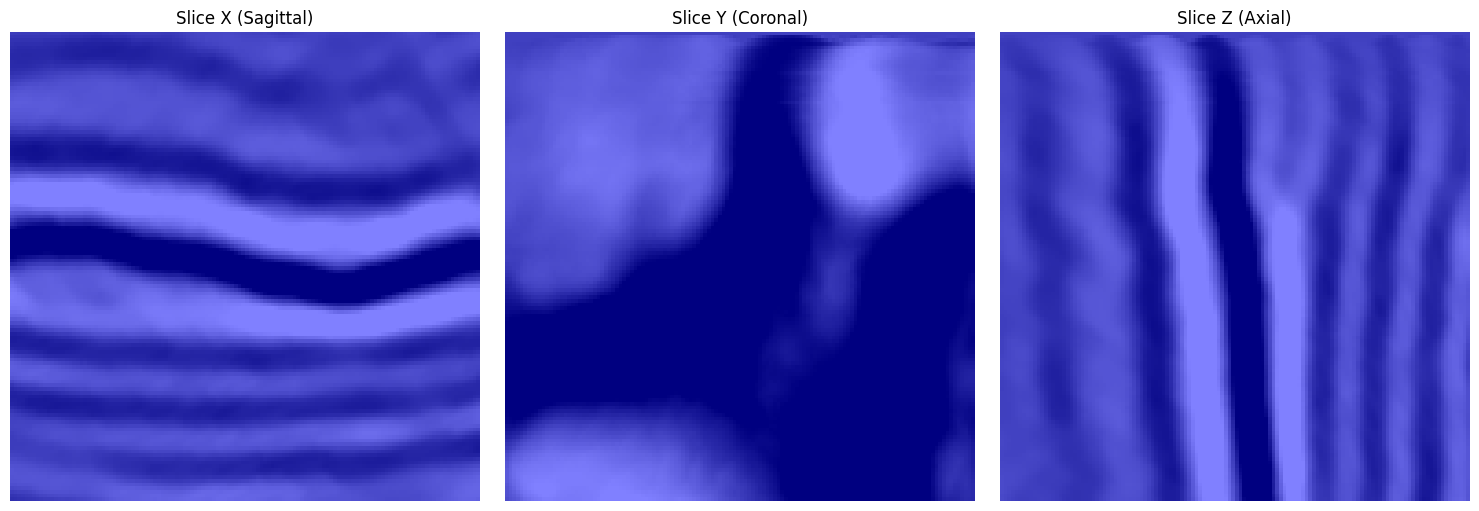

showing img 4


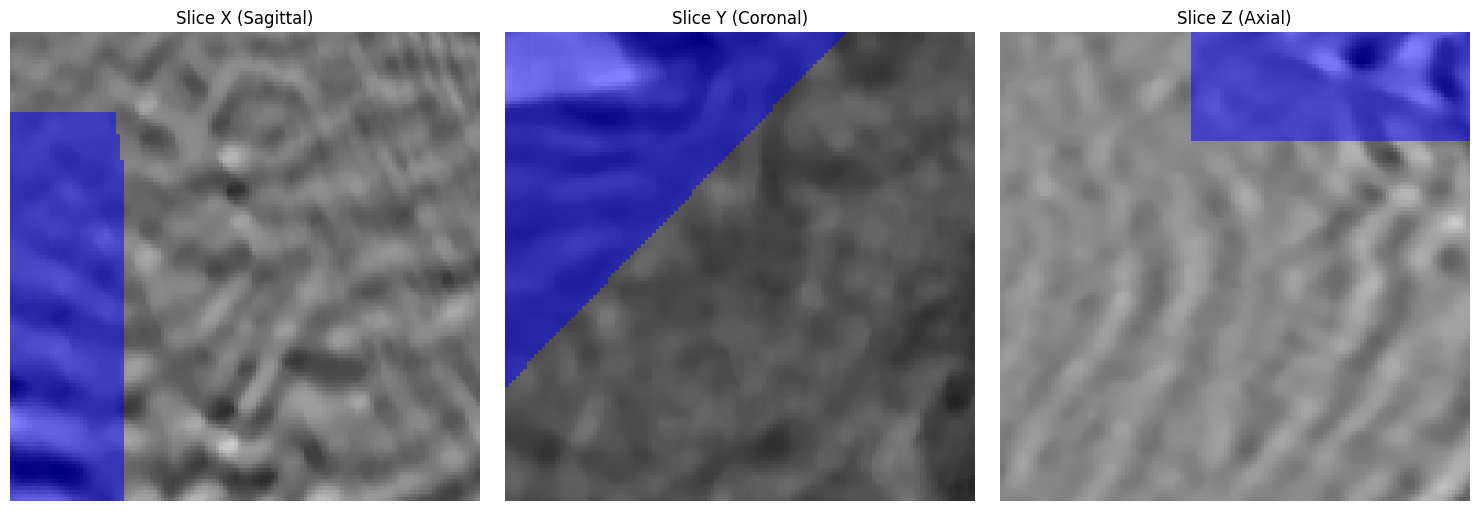

In [32]:
for i in range(5):
    print('showing img', i)
    img = np.load(getFile('database/processed/train/images', i))
    msk = np.load(getFile('database/processed/train/masks',  i))
    pasteMask(img, msk)